## Linear variation for cube

Total number of layers: 200.00
Generating plots...


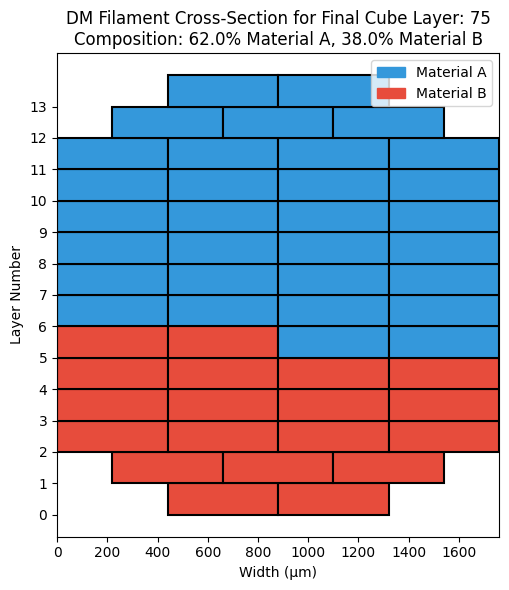


--- Filament Composition Summary ---
Total Filament Length: 1170.76 mm


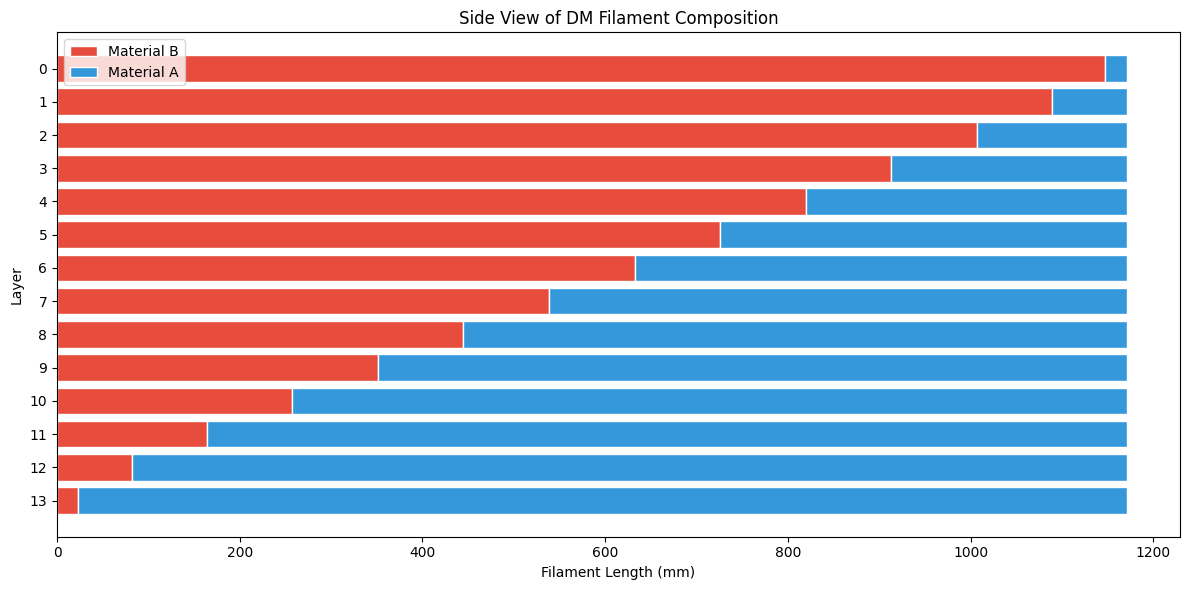

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np

# --- Parameters for the Final Object (Cube) ---
CUBE_SIDE_MM = 40
FINAL_LAYER_HEIGHT_MM = 0.2
TOTAL_FINAL_LAYERS = int(CUBE_SIDE_MM / FINAL_LAYER_HEIGHT_MM)

# [cite_start]The paper mentions an extrudate width of 440 µm [cite: 67]
EXTRUSION_WIDTH_MM = 0.44

# --- Parameters for the DM Filament ---
FILAMENT_DIAMETER_MM = 1.75
FILAMENT_LAYERS = 14
RECT_HEIGHT_UM = 125
RECT_WIDTH_UM = 440
RECTS_PER_LAYER = [2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2]
TOTAL_RECTS = sum(RECTS_PER_LAYER)

print(f"Total number of layers: {TOTAL_FINAL_LAYERS:.2f}")

# --- Cross-Section Generation Function ---
def generate_filament_cross_section(target_layer_index, total_final_layers):
    """s
    Generates the material distribution for a single segment of the DM filament
    using a simple bottom-up filling method.
    """
    if not (0 <= target_layer_index < total_final_layers):
        raise ValueError("target_layer_index must be between 0 and total_final_layers - 1.")
    percentage_B = target_layer_index / (total_final_layers - 1)
    num_B_rects_target = round(TOTAL_RECTS * percentage_B)
    cross_section = []
    rects_assigned_so_far = 0
    for num_rects_in_layer in RECTS_PER_LAYER:
        layer_composition = []
        for _ in range(num_rects_in_layer):
            if rects_assigned_so_far < num_B_rects_target:
                layer_composition.append('B')
            else:
                layer_composition.append('A')
            rects_assigned_so_far += 1
        cross_section.append(layer_composition)
    return cross_section

# --- Cross-Section Plotting Function (Unchanged) ---
def plot_cross_section(cross_section, layer_index):
    """
    Visualizes the generated DM filament cross-section with a layer-wise Y-axis.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    max_width = max(RECTS_PER_LAYER) * RECT_WIDTH_UM
    for i, layer in enumerate(cross_section):
        num_rects_in_layer = len(layer)
        start_x = (max_width - (num_rects_in_layer * RECT_WIDTH_UM)) / 2
        for j, material in enumerate(layer):
            color = '#3498db' if material == 'A' else '#e74c3c'
            y_pos = i * RECT_HEIGHT_UM
            x_pos = start_x + j * RECT_WIDTH_UM
            rect = patches.Rectangle(
                (x_pos, y_pos), RECT_WIDTH_UM, RECT_HEIGHT_UM,
                linewidth=1.5, edgecolor='black', facecolor=color
            )
            ax.add_patch(rect)

    ax.set_aspect('equal', adjustable='box')
    plt.xlim(0, max_width)
    total_height = FILAMENT_LAYERS * RECT_HEIGHT_UM
    plt.ylim(-total_height * 0.05, total_height * 1.05)
    plt.xlabel("Width (µm)")
    plt.ylabel("Layer Number")

    tick_positions = [i * RECT_HEIGHT_UM for i in range(FILAMENT_LAYERS)]
    tick_labels = [str(i) for i in range(FILAMENT_LAYERS)]
    plt.yticks(tick_positions, tick_labels)

    percentage_B = (sum(row.count('B') for row in cross_section) / TOTAL_RECTS) * 100
    title = (f"DM Filament Cross-Section for Final Cube Layer: {layer_index}\n"
             f"Composition: {100 - percentage_B:.1f}% Material A, {percentage_B:.1f}% Material B")
    plt.title(title)

    legend_patches = [
        patches.Patch(color='#3498db', label='Material A'),
        patches.Patch(color='#e74c3c', label='Material B')
    ]
    plt.legend(handles=legend_patches, loc='upper right')

    plt.grid(False)
    plt.tight_layout()
    plt.show()

# --- NEW: Function to Plot Filament Side View ---
def plot_filament_composition(layer_wise_lengths, total_filament_length):
    """
    Generates a stacked bar chart showing the composition of the entire filament.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    layers = np.arange(FILAMENT_LAYERS)
    lengths_A = [d['A'] for d in layer_wise_lengths]
    lengths_B = [d['B'] for d in layer_wise_lengths]

    # Plot Material B bars (red)
    ax.barh(layers, lengths_B, color='#e74c3c', edgecolor='white', label='Material B')
    # Plot Material A bars (blue) on top of Material B bars
    ax.barh(layers, lengths_A, left=lengths_B, color='#3498db', edgecolor='white', label='Material A')

    ax.set_xlabel('Filament Length (mm)')
    ax.set_ylabel('Layer')
    ax.set_title('Side View of DM Filament Composition')
    ax.set_yticks(layers)
    ax.invert_yaxis()  # To match the cross-section plot (layer 0 at bottom)
    ax.legend()

    print(f"\n--- Filament Composition Summary ---")
    print(f"Total Filament Length: {total_filament_length:.2f} mm")

    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # 1. Calculate length scaling factor based on volume conservation
    area_filament = math.pi * (FILAMENT_DIAMETER_MM / 2)**2
    area_extrusion = FINAL_LAYER_HEIGHT_MM * EXTRUSION_WIDTH_MM
    length_ratio = area_extrusion / area_filament

    # 2. Calculate length of filament needed PER LAYER of the final cube
    cube_perimeter_mm = 4 * CUBE_SIDE_MM
    extruded_length_per_layer = cube_perimeter_mm
    filament_length_per_layer = extruded_length_per_layer * length_ratio

    # 3. Loop through all final cube layers to aggregate data
    layer_wise_lengths = [{'A': 0, 'B': 0} for _ in range(FILAMENT_LAYERS)]

    for i in range(TOTAL_FINAL_LAYERS):
        cross_section = generate_filament_cross_section(i, TOTAL_FINAL_LAYERS)

        # For each of the 14 internal layers, calculate material length contribution
        for j, internal_layer in enumerate(cross_section):
            count_A = internal_layer.count('A')
            count_B = internal_layer.count('B')
            total_rects_in_layer = len(internal_layer)

            # Apportion this segment's length to A and B based on the cross-section
            len_A_segment = (count_A / total_rects_in_layer) * filament_length_per_layer
            len_B_segment = (count_B / total_rects_in_layer) * filament_length_per_layer

            layer_wise_lengths[j]['A'] += len_A_segment
            layer_wise_lengths[j]['B'] += len_B_segment

    total_filament_length = TOTAL_FINAL_LAYERS * filament_length_per_layer

    # 4. Generate the Plots
    print("Generating plots...")

    # Plot #1: Cross-section of a single, representative filament segment (e.g., for layer 75)
    plot_cross_section(generate_filament_cross_section(75, TOTAL_FINAL_LAYERS), 75)

    # Plot #2: The new side-view composition of the entire filament
    plot_filament_composition(layer_wise_lengths, total_filament_length)

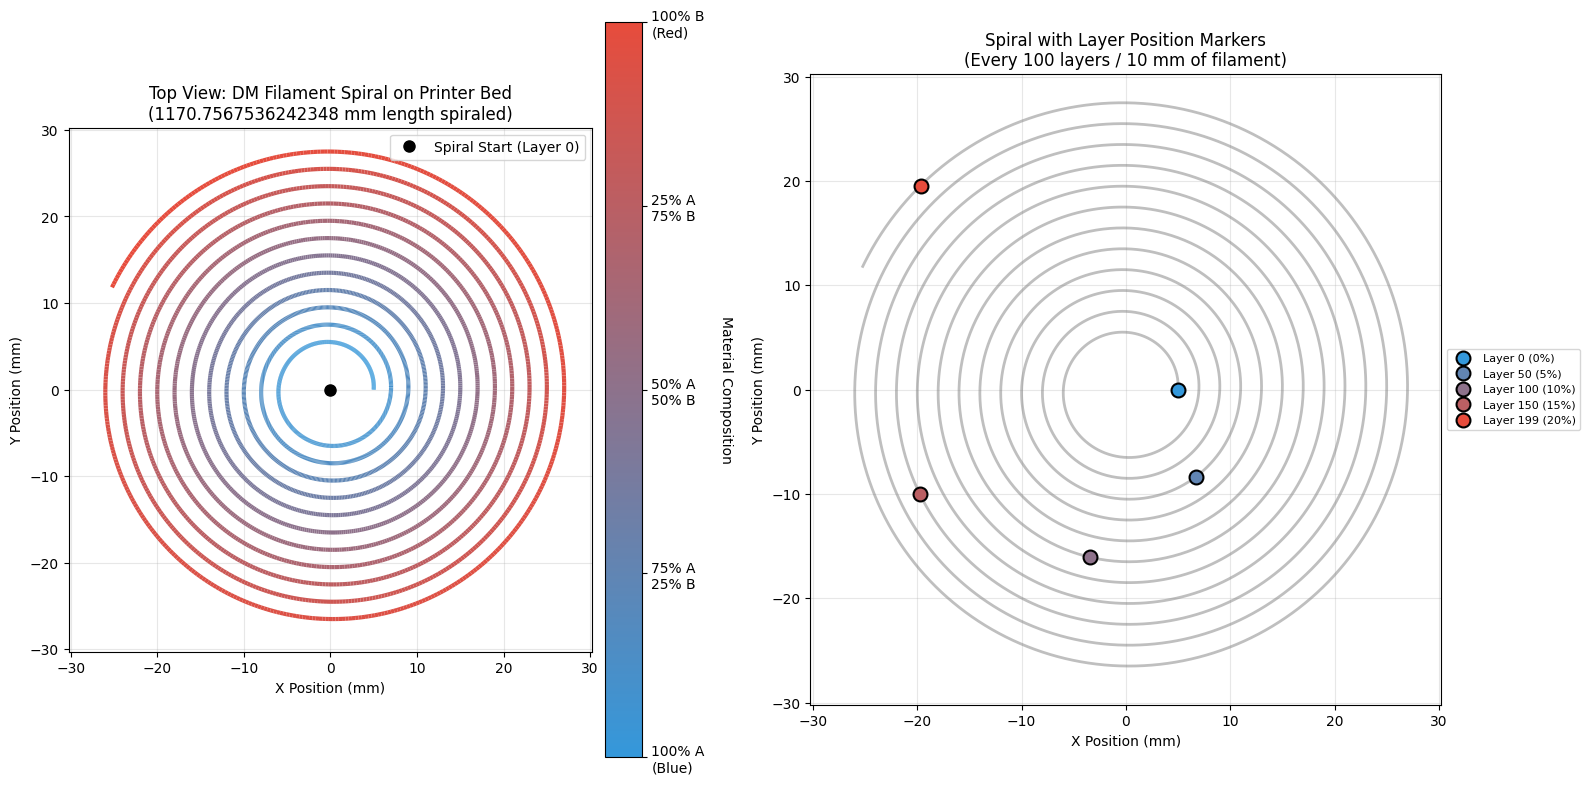


=== Spiral Statistics ===
Number of complete loops: 11.43
Final radius: 27.86 mm
Minimum bed diameter needed: 55.72 mm (5.6 cm)
Spiral start position: (0, 0)
Spiral end position: (-25.23, 11.81) mm

Color coding:
  - Blue (start): 100% Material A, 0% Material B
  - Purple (middle): ~50% Material A, ~50% Material B
  - Red (end): 0% Material A, 100% Material B


In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

# --- SPIRAL PARAMETERS ---
# The filament will be spiraled on the printer bed
SPIRAL_START_RADIUS_MM = 5  # Starting radius of the spiral
SPIRAL_SPACING_MM = 2.0  # Distance between spiral loops (should be >= filament diameter)
FILAMENT_LENGTH_MM = filament_length_per_layer * TOTAL_FINAL_LAYERS

def create_archimedean_spiral(total_length_mm, start_radius_mm, spacing_mm, num_points=5000):
    """
    Creates an Archimedean spiral path with a specific total length.

    Parameters:
    - total_length_mm: Total length of the spiral path
    - start_radius_mm: Starting radius of the spiral
    - spacing_mm: Distance between consecutive loops
    - num_points: Number of points to generate for smooth curve

    Returns:
    - x, y: Arrays of coordinates
    - theta: Array of angles
    """
    # Archimedean spiral: r = a + b*theta
    # where b = spacing / (2*pi) to get desired spacing
    b = spacing_mm / (2 * np.pi)
    a = start_radius_mm

    # Estimate theta_max needed to achieve the desired length
    # Arc length of Archimedean spiral is complex, so we iterate
    theta_max = 20 * np.pi  # Initial estimate (10 full rotations)

    for iteration in range(10):  # Iteratively refine
        theta = np.linspace(0, theta_max, num_points)
        r = a + b * theta

        # Calculate arc length numerically
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        dx = np.diff(x)
        dy = np.diff(y)
        segment_lengths = np.sqrt(dx**2 + dy**2)
        current_length = np.sum(segment_lengths)

        # Adjust theta_max
        theta_max *= total_length_mm / current_length

        if abs(current_length - total_length_mm) < 0.1:  # Within 0.1 mm tolerance
            break

    return x, y, theta, r

def plot_spiral_filament_gradient():
    """
    Visualizes the DM filament as a spiral with color gradient showing
    material composition from Material A (blue) to Material B (red).
    """
    # Generate spiral path
    x, y, theta, r = create_archimedean_spiral(
        FILAMENT_LENGTH_MM,
        SPIRAL_START_RADIUS_MM,
        SPIRAL_SPACING_MM
    )

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # --- LEFT PLOT: Spiral with gradient ---
    # Create color array representing material composition
    # 0 = 100% Material A (blue), 1 = 100% Material B (red)
    num_points = len(x)
    colors = np.linspace(0, 1, num_points)

    # Create line segments for coloring
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create custom colormap from blue to red
    cmap = LinearSegmentedColormap.from_list('material_gradient',
                                             ['#3498db', '#e74c3c'])

    # Create line collection with varying colors
    lc = LineCollection(segments, cmap=cmap, linewidth=3)
    lc.set_array(colors)

    line = ax1.add_collection(lc)

    # Set axis properties
    ax1.set_aspect('equal')
    max_extent = max(np.max(np.abs(x)), np.max(np.abs(y))) * 1.1
    ax1.set_xlim(-max_extent, max_extent)
    ax1.set_ylim(-max_extent, max_extent)
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    ax1.set_title(f'Top View: DM Filament Spiral on Printer Bed\n({FILAMENT_LENGTH_MM} mm length spiraled)')
    ax1.grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(line, ax=ax1, orientation='vertical', pad=0.02)
    cbar.set_label('Material Composition', rotation=270, labelpad=20)
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
    cbar.set_ticklabels(['100% A\n(Blue)', '75% A\n25% B', '50% A\n50% B',
                         '25% A\n75% B', '100% B\n(Red)'])

    # Add center marker
    ax1.plot(0, 0, 'ko', markersize=8, label='Spiral Start (Layer 0)')
    ax1.legend(loc='upper right')

    # --- RIGHT PLOT: Spiral with layer markers ---
    # Plot the spiral with markers at specific layer intervals
    ax2.plot(x, y, 'gray', linewidth=2, alpha=0.5)

    # Mark every 50 layers

    step = 50
    layer_markers = list(range(0, TOTAL_FINAL_LAYERS, step))
    last_layer = TOTAL_FINAL_LAYERS - 1
    if layer_markers[-1] != last_layer:
        layer_markers.append(last_layer)

    marker_colors = [cmap(i / last_layer) for i in layer_markers]

    for layer_idx, color in zip(layer_markers, marker_colors):
        idx = int(layer_idx / TOTAL_FINAL_LAYERS * len(x))
        idx = min(idx, len(x) - 1)
        ax2.plot(x[idx], y[idx], 'o', color=color, markersize=10,
                markeredgecolor='black', markeredgewidth=1.5,
                label=f'Layer {layer_idx} ({layer_idx/10:.0f}%)')

    ax2.set_aspect('equal')
    ax2.set_xlim(-max_extent, max_extent)
    ax2.set_ylim(-max_extent, max_extent)
    ax2.set_xlabel('X Position (mm)')
    ax2.set_ylabel('Y Position (mm)')
    ax2.set_title(f'Spiral with Layer Position Markers\n(Every 100 layers / 10 mm of filament)')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

    plt.tight_layout()
    plt.show()

    # Print spiral statistics
    final_radius = SPIRAL_START_RADIUS_MM + (SPIRAL_SPACING_MM / (2 * np.pi)) * theta[-1]
    num_loops = theta[-1] / (2 * np.pi)
    bed_diameter_needed = 2 * final_radius

    print(f"\n=== Spiral Statistics ===")
    print(f"Number of complete loops: {num_loops:.2f}")
    print(f"Final radius: {final_radius:.2f} mm")
    print(f"Minimum bed diameter needed: {bed_diameter_needed:.2f} mm ({bed_diameter_needed/10:.1f} cm)")
    print(f"Spiral start position: (0, 0)")
    print(f"Spiral end position: ({x[-1]:.2f}, {y[-1]:.2f}) mm")
    print(f"\nColor coding:")
    print(f"  - Blue (start): 100% Material A, 0% Material B")
    print(f"  - Purple (middle): ~50% Material A, ~50% Material B")
    print(f"  - Red (end): 0% Material A, 100% Material B")

# Generate the visualization
plot_spiral_filament_gradient()

Generating 3D visualization of the cube... (This may take a moment)


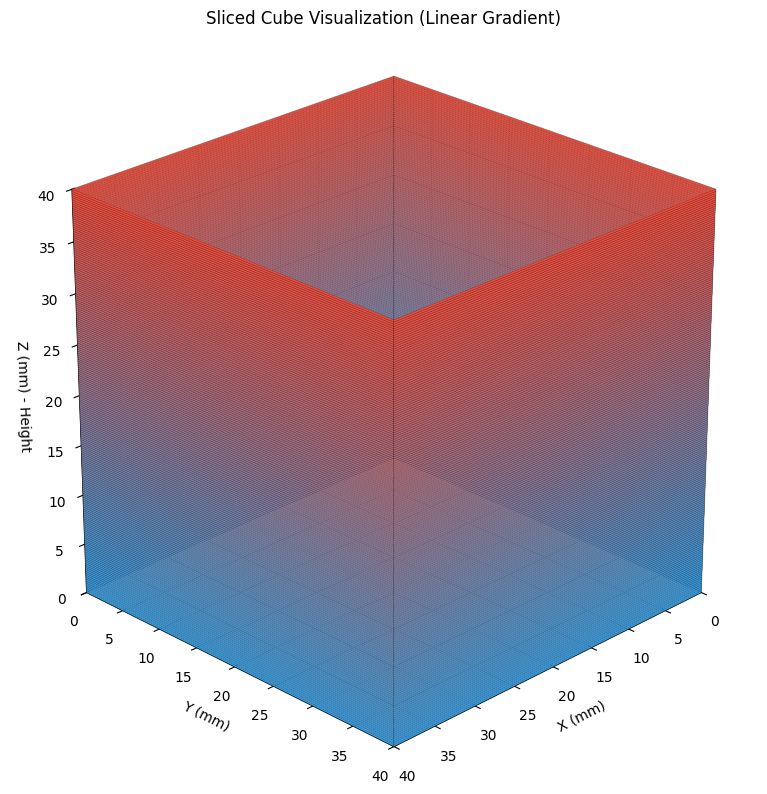

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# --- Define the colors for Material A (start) and Material B (end) ---
COLOR_A = np.array([52, 152, 219]) / 255.0  # Blue
COLOR_B = np.array([231, 76, 60]) / 255.0   # Red

def get_layer_color(layer_index, total_layers):
    """
    Calculates the RGB color for a given layer based on a LINEAR gradient.
    """
    if total_layers == 1:
        return COLOR_A

    normalized_layer = layer_index / (total_layers - 1)

    # === CHANGE: FROM QUADRATIC TO LINEAR ===
    # Previously: percentage_B = normalized_layer ** 2
    percentage_B = normalized_layer
    # =========================================

    # Linearly interpolate between the two colors
    color = COLOR_A * (1 - percentage_B) + COLOR_B * percentage_B
    return color

def visualize_sliced_cube():
    """
    Creates a 3D plot of the cube, showing individual layers and color gradient.
    """
    print("Generating 3D visualization of the cube... (This may take a moment)")

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i in range(TOTAL_FINAL_LAYERS):
        z_bottom = i * FINAL_LAYER_HEIGHT_MM
        z_top = (i + 1) * FINAL_LAYER_HEIGHT_MM

        layer_color = get_layer_color(i, TOTAL_FINAL_LAYERS)

        L = CUBE_SIDE_MM
        verts = [
            [(0, 0, z_bottom), (L, 0, z_bottom), (L, 0, z_top), (0, 0, z_top)],
            [(L, 0, z_bottom), (L, L, z_bottom), (L, L, z_top), (L, 0, z_top)],
            [(L, L, z_bottom), (0, L, z_bottom), (0, L, z_top), (L, L, z_top)],
            [(0, L, z_bottom), (0, 0, z_bottom), (0, 0, z_top), (0, L, z_top)]
        ]

        wall_collection = Poly3DCollection(verts, facecolors=layer_color,
                                           edgecolor='k', linewidth=0.1)
        ax.add_collection3d(wall_collection)

    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm) - Height')
    ax.set_title('Sliced Cube Visualization (Linear Gradient)')

    ax.set_xlim([0, CUBE_SIDE_MM])
    ax.set_ylim([0, CUBE_SIDE_MM])
    ax.set_zlim([0, CUBE_SIDE_MM])

    ax.view_init(elev=25, azim=45)

    ax.set_box_aspect([1, 1, 1])

    plt.tight_layout()
    plt.show()

# --- Run the visualization ---
if __name__ == "__main__":
    visualize_sliced_cube()

 ## Quadratic Variation for cube

Total number of layers: 200
Generating plots...


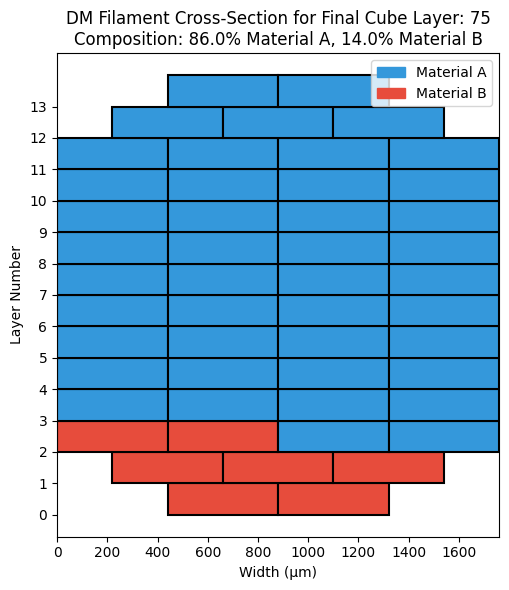


--- Filament Composition Summary ---
Total Filament Length: 1170.76 mm


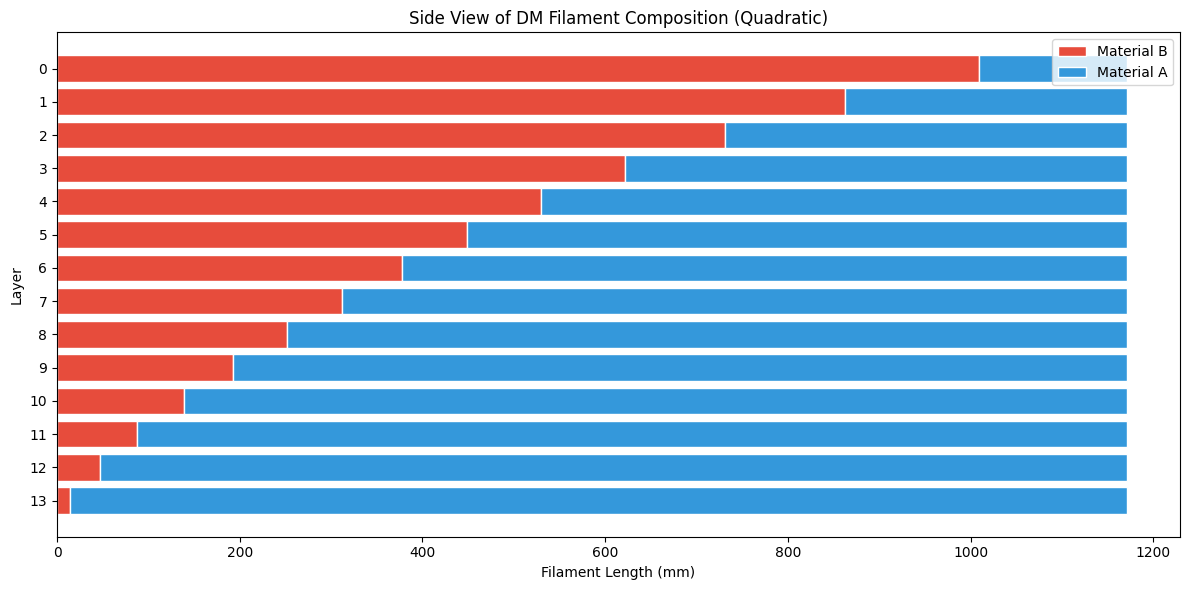

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np

# --- Parameters for the Final Object (The Cube) ---
CUBE_SIDE_MM = 40
FINAL_LAYER_HEIGHT_MM = 0.2
TOTAL_FINAL_LAYERS = int(CUBE_SIDE_MM / FINAL_LAYER_HEIGHT_MM)

# [cite_start]The paper mentions an extrudate width of 440 µm [cite: 67]
EXTRUSION_WIDTH_MM = 0.44

# --- Parameters for the DM Filament ---
FILAMENT_DIAMETER_MM = 1.75
FILAMENT_LAYERS = 14
RECT_HEIGHT_UM = 125
RECT_WIDTH_UM = 440
RECTS_PER_LAYER = [2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2]
TOTAL_RECTS = sum(RECTS_PER_LAYER)

print(f"Total number of layers: {TOTAL_FINAL_LAYERS}")

# --- Cross-Section Generation Function (MODIFIED) ---
def generate_filament_cross_section(target_layer_index, total_final_layers):
    """
    Generates the material distribution for a single segment of the DM filament
    using a simple bottom-up filling method with a QUADRATIC distribution.
    """
    if not (0 <= target_layer_index < total_final_layers):
        raise ValueError("target_layer_index must be between 0 and total_final_layers - 1.")

    # --- MODIFICATION FROM LINEAR TO QUADRATIC ---
    # Normalize the layer index to a 0-1 scale
    normalized_layer = target_layer_index / (total_final_layers - 1)
    # Apply a quadratic function (y = x^2) for a slow-start, fast-finish gradient
    percentage_B = normalized_layer ** 2
    # --- END OF MODIFICATION ---

    num_B_rects_target = round(TOTAL_RECTS * percentage_B)
    cross_section = []
    rects_assigned_so_far = 0
    for num_rects_in_layer in RECTS_PER_LAYER:
        layer_composition = []
        for _ in range(num_rects_in_layer):
            if rects_assigned_so_far < num_B_rects_target:
                layer_composition.append('B')
            else:
                layer_composition.append('A')
            rects_assigned_so_far += 1
        cross_section.append(layer_composition)
    return cross_section

# --- Cross-Section Plotting Function (Unchanged) ---
def plot_cross_section(cross_section, layer_index):
    """
    Visualizes the generated DM filament cross-section with a layer-wise Y-axis.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    max_width = max(RECTS_PER_LAYER) * RECT_WIDTH_UM
    for i, layer in enumerate(cross_section):
        num_rects_in_layer = len(layer)
        start_x = (max_width - (num_rects_in_layer * RECT_WIDTH_UM)) / 2
        for j, material in enumerate(layer):
            color = '#3498db' if material == 'A' else '#e74c3c'
            y_pos = i * RECT_HEIGHT_UM
            x_pos = start_x + j * RECT_WIDTH_UM
            rect = patches.Rectangle(
                (x_pos, y_pos), RECT_WIDTH_UM, RECT_HEIGHT_UM,
                linewidth=1.5, edgecolor='black', facecolor=color
            )
            ax.add_patch(rect)

    ax.set_aspect('equal', adjustable='box')
    plt.xlim(0, max_width)
    total_height = FILAMENT_LAYERS * RECT_HEIGHT_UM
    plt.ylim(-total_height * 0.05, total_height * 1.05)
    plt.xlabel("Width (µm)")
    plt.ylabel("Layer Number")

    tick_positions = [i * RECT_HEIGHT_UM for i in range(FILAMENT_LAYERS)]
    tick_labels = [str(i) for i in range(FILAMENT_LAYERS)]
    plt.yticks(tick_positions, tick_labels)

    percentage_B = (sum(row.count('B') for row in cross_section) / TOTAL_RECTS) * 100
    title = (f"DM Filament Cross-Section for Final Cube Layer: {layer_index}\n"
             f"Composition: {100 - percentage_B:.1f}% Material A, {percentage_B:.1f}% Material B")
    plt.title(title)

    legend_patches = [
        patches.Patch(color='#3498db', label='Material A'),
        patches.Patch(color='#e74c3c', label='Material B')
    ]
    plt.legend(handles=legend_patches, loc='upper right')

    plt.grid(False)
    plt.tight_layout()
    plt.show()

# --- Side View Plotting Function (Title Changed) ---
def plot_filament_composition(layer_wise_lengths, total_filament_length):
    """
    Generates a stacked bar chart showing the composition of the entire filament.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    layers = np.arange(FILAMENT_LAYERS)
    lengths_A = [d['A'] for d in layer_wise_lengths]
    lengths_B = [d['B'] for d in layer_wise_lengths]

    # Plot Material B bars (red)
    ax.barh(layers, lengths_B, color='#e74c3c', edgecolor='white', label='Material B')
    # Plot Material A bars (blue) on top of Material B bars
    ax.barh(layers, lengths_A, left=lengths_B, color='#3498db', edgecolor='white', label='Material A')

    ax.set_xlabel('Filament Length (mm)')
    ax.set_ylabel('Layer')
    ax.set_title('Side View of DM Filament Composition (Quadratic)')
    ax.set_yticks(layers)
    ax.invert_yaxis()  # To match the cross-section plot (layer 0 at bottom)
    ax.legend()

    print(f"\n--- Filament Composition Summary ---")
    print(f"Total Filament Length: {total_filament_length:.2f} mm")

    plt.tight_layout()
    plt.show()

# --- Main Execution (Unchanged) ---
if __name__ == "__main__":
    # 1. Calculate length scaling factor based on volume conservation
    area_filament = math.pi * (FILAMENT_DIAMETER_MM / 2)**2
    area_extrusion = FINAL_LAYER_HEIGHT_MM * EXTRUSION_WIDTH_MM
    length_ratio = area_extrusion / area_filament

    # 2. Calculate length of filament needed PER LAYER of the final cube
    cube_perimeter_mm = 4 * CUBE_SIDE_MM
    extruded_length_per_layer = cube_perimeter_mm
    filament_length_per_layer = extruded_length_per_layer * length_ratio

    # 3. Loop through all final cube layers to aggregate data
    layer_wise_lengths = [{'A': 0, 'B': 0} for _ in range(FILAMENT_LAYERS)]

    for i in range(TOTAL_FINAL_LAYERS):
        cross_section = generate_filament_cross_section(i, TOTAL_FINAL_LAYERS)

        # For each of the 14 internal layers, calculate material length contribution
        for j, internal_layer in enumerate(cross_section):
            count_A = internal_layer.count('A')
            count_B = internal_layer.count('B')
            total_rects_in_layer = len(internal_layer)

            # Apportion this segment's length to A and B based on the cross-section
            len_A_segment = (count_A / total_rects_in_layer) * filament_length_per_layer
            len_B_segment = (count_B / total_rects_in_layer) * filament_length_per_layer

            layer_wise_lengths[j]['A'] += len_A_segment
            layer_wise_lengths[j]['B'] += len_B_segment

    total_filament_length = TOTAL_FINAL_LAYERS * filament_length_per_layer

    # 4. Generate the Plots
    print("Generating plots...")

    # Plot #1: Cross-section of a single, representative filament segment (e.g., for layer 75)
    plot_cross_section(generate_filament_cross_section(75, TOTAL_FINAL_LAYERS), 75)

    # Plot #2: The new side-view composition of the entire filament
    plot_filament_composition(layer_wise_lengths, total_filament_length)

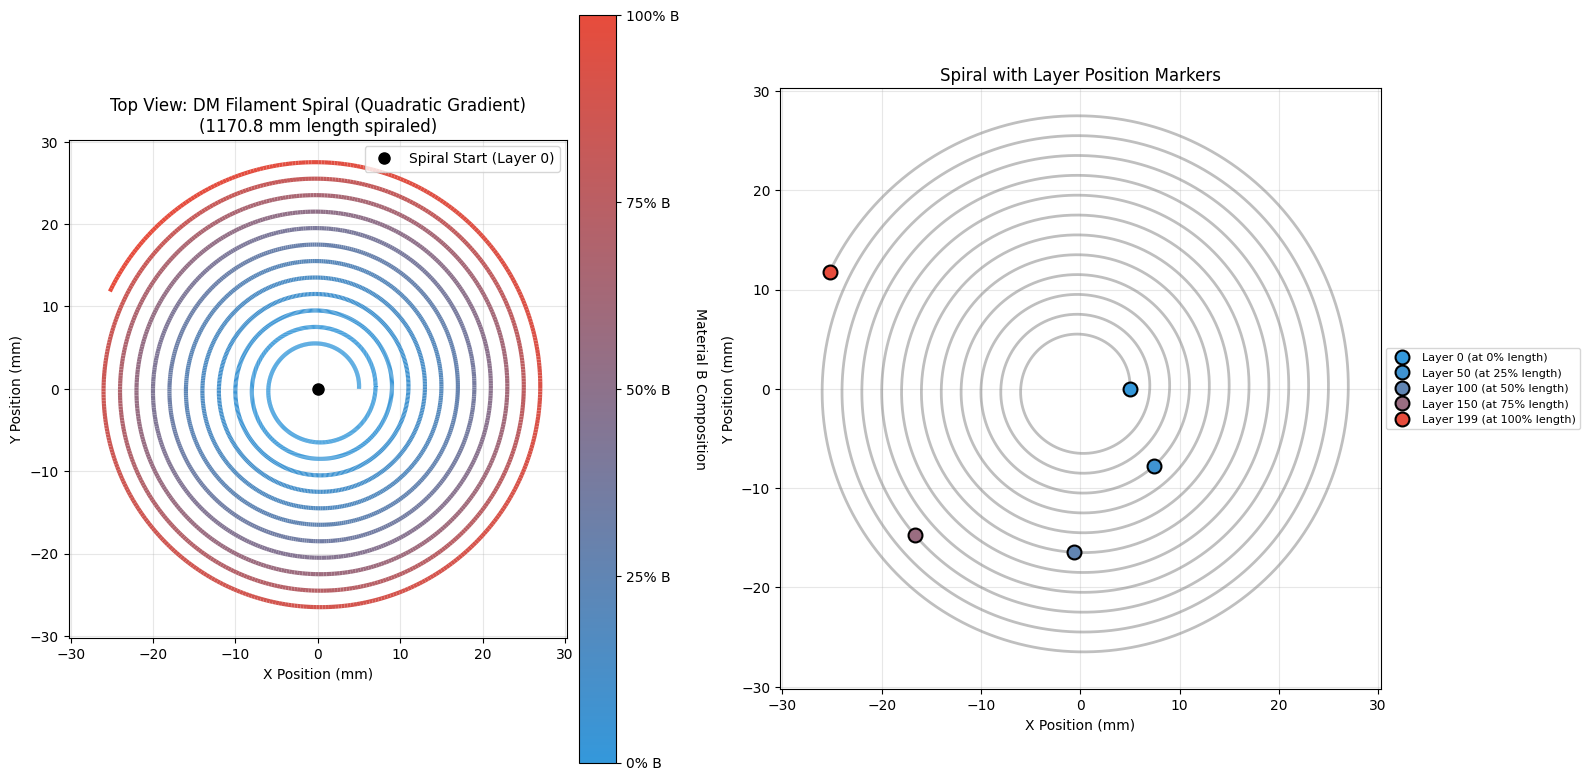


=== Spiral Statistics ===
Number of complete loops: 11.43
Final radius: 27.86 mm
Minimum bed diameter needed: 55.72 mm (5.6 cm)


In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
import math # Added for calculation

# --- Re-establishing necessary parameters from previous code ---
CUBE_SIDE_MM = 40
FINAL_LAYER_HEIGHT_MM = 0.2
TOTAL_FINAL_LAYERS = int(CUBE_SIDE_MM / FINAL_LAYER_HEIGHT_MM)
EXTRUSION_WIDTH_MM = 0.44
FILAMENT_DIAMETER_MM = 1.75

# Calculate total filament length
area_filament = math.pi * (FILAMENT_DIAMETER_MM / 2)**2
area_extrusion = FINAL_LAYER_HEIGHT_MM * EXTRUSION_WIDTH_MM
length_ratio = area_extrusion / area_filament
cube_perimeter_mm = 4 * CUBE_SIDE_MM
extruded_length_per_layer = cube_perimeter_mm
filament_length_per_layer = extruded_length_per_layer * length_ratio
FILAMENT_LENGTH_MM = filament_length_per_layer * TOTAL_FINAL_LAYERS
# --- End of parameter setup ---


# --- SPIRAL PARAMETERS ---
SPIRAL_START_RADIUS_MM = 5
SPIRAL_SPACING_MM = 2.0

def create_archimedean_spiral(total_length_mm, start_radius_mm, spacing_mm, num_points=5000):
    """
    Creates an Archimedean spiral path with a specific total length. (This function is unchanged)
    """
    b = spacing_mm / (2 * np.pi)
    a = start_radius_mm

    theta_max = 20 * np.pi

    for iteration in range(10):
        theta = np.linspace(0, theta_max, num_points)
        r = a + b * theta

        x = r * np.cos(theta)
        y = r * np.sin(theta)
        dx = np.diff(x)
        dy = np.diff(y)
        segment_lengths = np.sqrt(dx**2 + dy**2)
        current_length = np.sum(segment_lengths)

        theta_max *= total_length_mm / current_length

        if abs(current_length - total_length_mm) < 0.1:
            break

    return x, y, theta, r

def plot_spiral_filament_gradient():
    """
    Visualizes the DM filament as a spiral with a QUADRATIC color gradient.
    """
    x, y, theta, r = create_archimedean_spiral(
        FILAMENT_LENGTH_MM,
        SPIRAL_START_RADIUS_MM,
        SPIRAL_SPACING_MM
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # --- LEFT PLOT: Spiral with gradient ---
    num_points = len(x)

    # Previously, this was: colors = np.linspace(0, 1, num_points)
    # Now, we create a linear base and square it for a quadratic distribution.
    normalized_position = np.linspace(0, 1, num_points)
    colors = normalized_position ** 2

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    cmap = LinearSegmentedColormap.from_list('material_gradient',
                                             ['#3498db', '#e74c3c'])

    lc = LineCollection(segments, cmap=cmap, linewidth=3)
    lc.set_array(colors)

    line = ax1.add_collection(lc)

    ax1.set_aspect('equal')
    max_extent = max(np.max(np.abs(x)), np.max(np.abs(y))) * 1.1
    ax1.set_xlim(-max_extent, max_extent)
    ax1.set_ylim(-max_extent, max_extent)
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    ax1.set_title(f'Top View: DM Filament Spiral (Quadratic Gradient)\n({FILAMENT_LENGTH_MM:.1f} mm length spiraled)')
    ax1.grid(True, alpha=0.3)

    # The labels are updated to reflect the non-linear composition.
    cbar = plt.colorbar(line, ax=ax1, orientation='vertical', pad=0.02)
    cbar.set_label('Material B Composition', rotation=270, labelpad=20)
    cbar.set_ticks([0, 0.25, 0.50, 0.75, 1.0])
    cbar.set_ticklabels(['0% B', '25% B', '50% B', '75% B', '100% B'])

    ax1.plot(0, 0, 'ko', markersize=8, label='Spiral Start (Layer 0)')
    ax1.legend(loc='upper right')

    # --- RIGHT PLOT: Spiral with layer markers ---
    ax2.plot(x, y, 'gray', linewidth=2, alpha=0.5)

    step = 50
    layer_markers = list(range(0, TOTAL_FINAL_LAYERS, step))
    last_layer = TOTAL_FINAL_LAYERS - 1
    if layer_markers[-1] != last_layer:
        layer_markers.append(last_layer)

    # The color of each marker is now also calculated using the quadratic formula.
    # Previously: cmap(i / last_layer)
    marker_colors = [cmap((i / last_layer)**2) for i in layer_markers]

    for layer_idx, color in zip(layer_markers, marker_colors):
        # Position is still linear along the length
        idx = int(layer_idx / (TOTAL_FINAL_LAYERS - 1) * (len(x) - 1))

        # The label now clarifies the layer position and its percentage along the length.
        percentage_length = (layer_idx / (TOTAL_FINAL_LAYERS - 1)) * 100
        ax2.plot(x[idx], y[idx], 'o', color=color, markersize=10,
                markeredgecolor='black', markeredgewidth=1.5,
                label=f'Layer {layer_idx} (at {percentage_length:.0f}% length)')

    ax2.set_aspect('equal')
    ax2.set_xlim(-max_extent, max_extent)
    ax2.set_ylim(-max_extent, max_extent)
    ax2.set_xlabel('X Position (mm)')
    ax2.set_ylabel('Y Position (mm)')
    ax2.set_title(f'Spiral with Layer Position Markers')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

    plt.tight_layout()
    plt.show()

    final_radius = SPIRAL_START_RADIUS_MM + (SPIRAL_SPACING_MM / (2 * np.pi)) * theta[-1]
    num_loops = theta[-1] / (2 * np.pi)
    bed_diameter_needed = 2 * final_radius

    print(f"\n=== Spiral Statistics ===")
    print(f"Number of complete loops: {num_loops:.2f}")
    print(f"Final radius: {final_radius:.2f} mm")
    print(f"Minimum bed diameter needed: {bed_diameter_needed:.2f} mm ({bed_diameter_needed/10:.1f} cm)")

# Generate the visualization
plot_spiral_filament_gradient()

Generating 3D visualization of the cube... (This may take a moment)


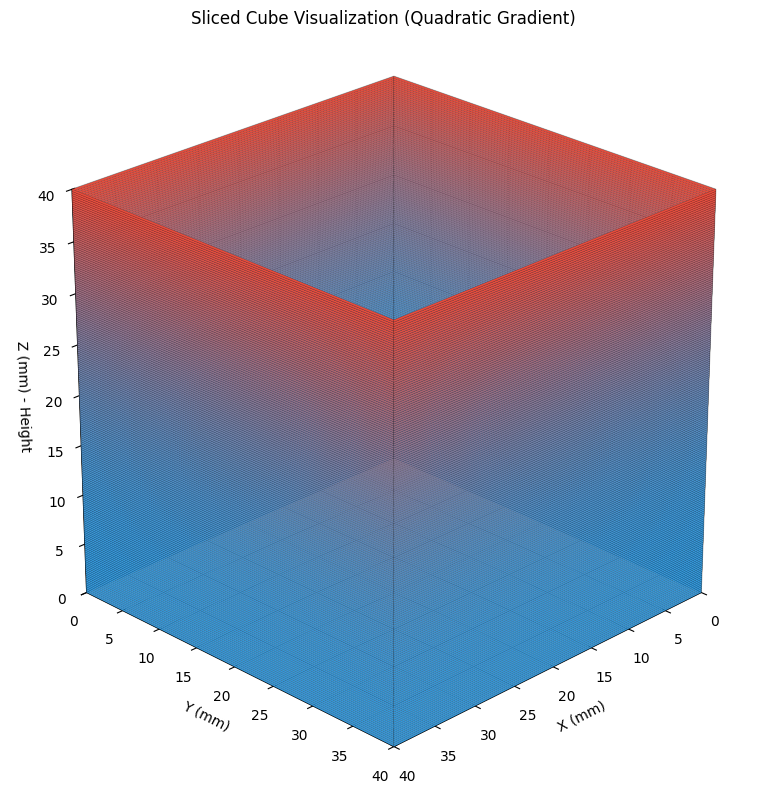

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# --- Define the colors for Material A (start) and Material B (end) ---
# Using the same hex codes as before: #3498db (blue) and #e74c3c (red)
COLOR_A = np.array([52, 152, 219]) / 255.0
COLOR_B = np.array([231, 76, 60]) / 255.0

def get_layer_color(layer_index, total_layers):
    """
    Calculates the RGB color for a given layer based on a quadratic gradient.
    """
    if total_layers == 1:
        return COLOR_A

    # Normalize the layer index to a 0-1 scale
    normalized_layer = layer_index / (total_layers - 1)

    # Apply the quadratic function (y = x^2)
    percentage_B = normalized_layer ** 2

    # Linearly interpolate between the two colors based on the percentage
    color = COLOR_A * (1 - percentage_B) + COLOR_B * percentage_B
    return color

def visualize_sliced_cube():
    """
    Creates a 3D plot of the cube, showing individual layers and color gradient.
    """
    print("Generating 3D visualization of the cube... (This may take a moment)")

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Loop through each layer of the cube from bottom to top
    for i in range(TOTAL_FINAL_LAYERS):
        # Define the bottom and top Z coordinates for the current layer
        z_bottom = i * FINAL_LAYER_HEIGHT_MM
        z_top = (i + 1) * FINAL_LAYER_HEIGHT_MM

        # Get the appropriate color for this layer
        layer_color = get_layer_color(i, TOTAL_FINAL_LAYERS)

        # Define the vertices for the four walls of the square layer
        L = CUBE_SIDE_MM
        verts = [
            # Front wall
            [(0, 0, z_bottom), (L, 0, z_bottom), (L, 0, z_top), (0, 0, z_top)],
            # Right wall
            [(L, 0, z_bottom), (L, L, z_bottom), (L, L, z_top), (L, 0, z_top)],
            # Back wall
            [(L, L, z_bottom), (0, L, z_bottom), (0, L, z_top), (L, L, z_top)],
            # Left wall
            [(0, L, z_bottom), (0, 0, z_bottom), (0, 0, z_top), (0, L, z_top)]
        ]

        # Create a 3D polygon collection for the walls
        # A thin black edge helps to visually separate the layers
        wall_collection = Poly3DCollection(verts, facecolors=layer_color,
                                           edgecolor='k', linewidth=0.1)
        ax.add_collection3d(wall_collection)

    # --- Setting up the plot aesthetics ---
    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm) - Height')
    ax.set_title('Sliced Cube Visualization (Quadratic Gradient)')

    # Set axis limits to neatly frame the cube
    ax.set_xlim([0, CUBE_SIDE_MM])
    ax.set_ylim([0, CUBE_SIDE_MM])
    ax.set_zlim([0, CUBE_SIDE_MM])

    # Set a good viewing angle
    ax.view_init(elev=25, azim=45)

    ax.set_box_aspect([1, 1, 1])  # Aspect ratio is 1:1:1

    plt.tight_layout()
    plt.show()

# --- Run the visualization ---
if __name__ == "__main__":
    visualize_sliced_cube()

## Quadratic variation for Cylinder

--- Hollow Cylinder Parameters ---
Height: 40.0 mm, Total Layers: 200
Outer Radius: 20.00 mm, Inner Radius: 17.80 mm
Wall Thickness: 2.20 mm
Wall filled with 5 perimeter(s).
Extruded length per layer: 593.76 mm
Total Filament Length: 4344.69 mm


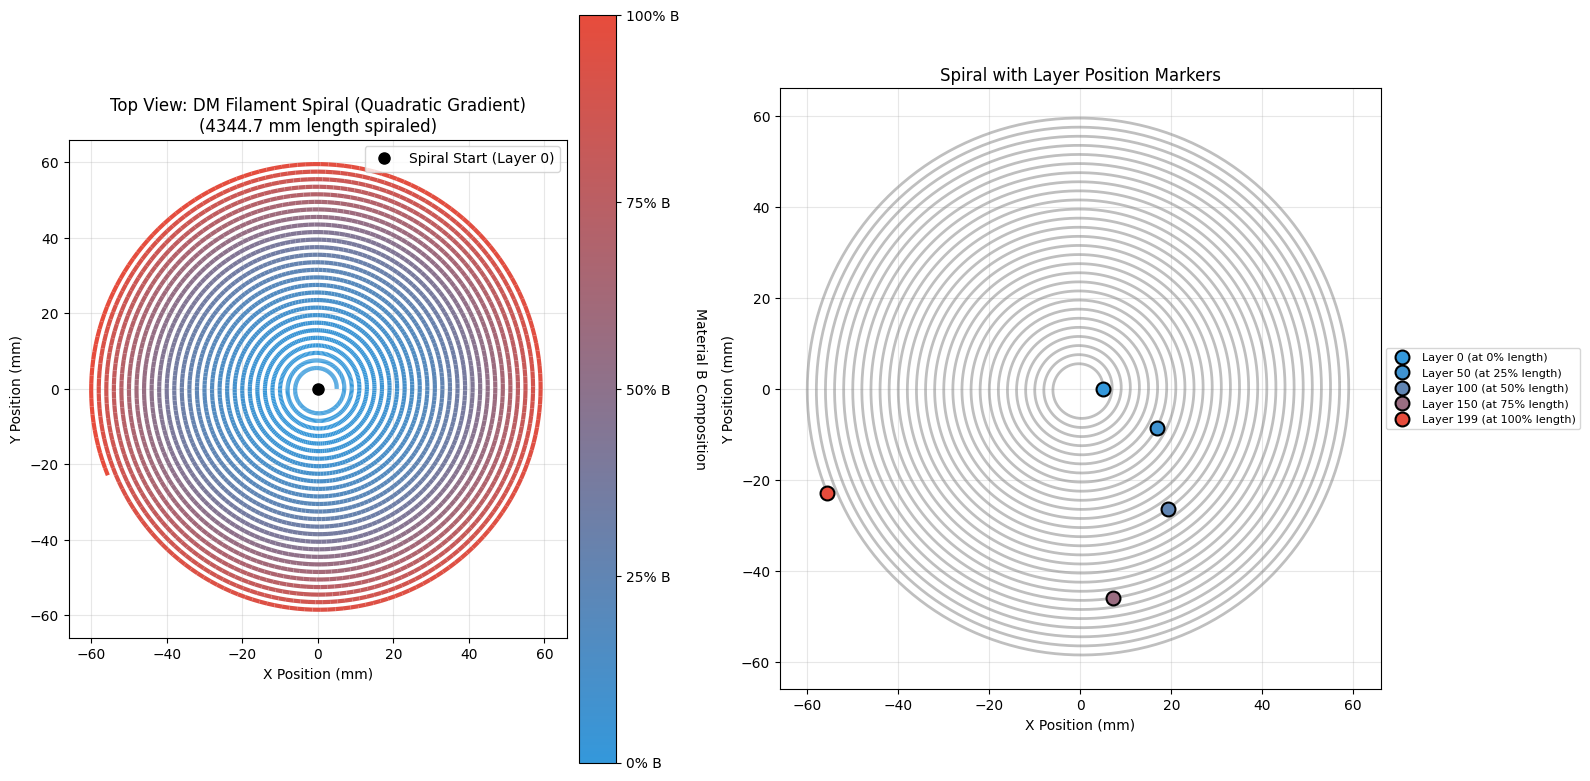


=== Spiral Statistics ===
Number of complete loops: 27.56
Final radius: 60.12 mm
Minimum bed diameter needed: 120.25 mm (12.0 cm)

Generating 3D visualization of the hollow cylinder...


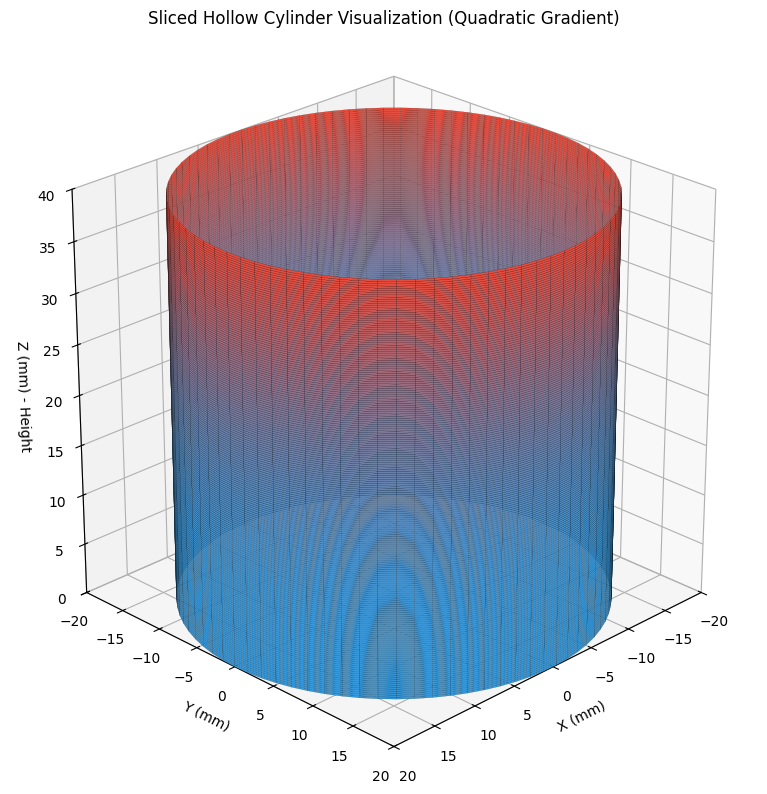

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math

# ---------------------- PARAMETERS ----------------------

# --- Final Object (Hollow Cylinder) ---
CYLINDER_HEIGHT_MM = 40.0
OUTER_RADIUS_MM = 20.0
WALL_THICKNESS_MM = 2.2
INNER_RADIUS_MM = max(0.0, OUTER_RADIUS_MM - WALL_THICKNESS_MM)
FINAL_LAYER_HEIGHT_MM = 0.2
TOTAL_FINAL_LAYERS = int(CYLINDER_HEIGHT_MM / FINAL_LAYER_HEIGHT_MM)

# --- Print Settings ---
EXTRUSION_WIDTH_MM = 0.44

# --- DM Filament ---
FILAMENT_DIAMETER_MM = 1.75

# --- Spiral Settings ---
SPIRAL_START_RADIUS_MM = 5.0
SPIRAL_SPACING_MM = 2.0

# --- 3D Visualization Settings ---
CYLINDER_MESH_SEGMENTS = 80 # Segments for a smooth 3D cylinder

# --- Colors ---
COLOR_A_RGB = np.array([52, 152, 219]) / 255.0  # Blue
COLOR_B_RGB = np.array([231, 76, 60]) / 255.0   # Red
COLOR_A_HEX = '#3498db'
COLOR_B_HEX = '#e74c3c'

# ------------------------------------------------------------------
# ### 1. Filament Length Calculation (for Cylinder)
# ------------------------------------------------------------------

def calculate_cylinder_filament_length():
    """
    Calculates total filament length needed for the hollow cylinder.
    """
    # Volume conservation
    area_filament = math.pi * (FILAMENT_DIAMETER_MM / 2)**2
    area_extrusion = FINAL_LAYER_HEIGHT_MM * EXTRUSION_WIDTH_MM
    length_ratio = area_extrusion / area_filament

    # Calculate number of perimeters
    num_perimeters = max(1, int(round(WALL_THICKNESS_MM / EXTRUSION_WIDTH_MM)))
    
    # Define radii for each perimeter path (center of the extrusion)
    perimeter_radii = [INNER_RADIUS_MM + (k + 0.5) * EXTRUSION_WIDTH_MM for k in range(num_perimeters)]
    
    # Extruded length per layer = sum of circumferences
    extruded_length_per_layer = sum([2 * math.pi * r for r in perimeter_radii])
    filament_length_per_layer = extruded_length_per_layer * length_ratio

    print(f"--- Hollow Cylinder Parameters ---")
    print(f"Height: {CYLINDER_HEIGHT_MM} mm, Total Layers: {TOTAL_FINAL_LAYERS}")
    print(f"Outer Radius: {OUTER_RADIUS_MM:.2f} mm, Inner Radius: {INNER_RADIUS_MM:.2f} mm")
    print(f"Wall Thickness: {WALL_THICKNESS_MM:.2f} mm")
    print(f"Wall filled with {num_perimeters} perimeter(s).")
    print(f"Extruded length per layer: {extruded_length_per_layer:.2f} mm")
    
    total_filament_length = TOTAL_FINAL_LAYERS * filament_length_per_layer
    print(f"Total Filament Length: {total_filament_length:.2f} mm")
    
    return total_filament_length

# ------------------------------------------------------------------
# ### 2. Spiral Plot (Quadratic)
# ------------------------------------------------------------------

def create_archimedean_spiral(total_length_mm, start_radius_mm, spacing_mm, num_points=5000):
    """
    Creates an Archimedean spiral path with a specific total length.
    """
    b = spacing_mm / (2 * np.pi)
    a = start_radius_mm
    theta_max = 20 * np.pi
    for iteration in range(10):
        theta = np.linspace(0, theta_max, num_points)
        r = a + b * theta
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        dx = np.diff(x)
        dy = np.diff(y)
        segment_lengths = np.sqrt(dx**2 + dy**2)
        current_length = np.sum(segment_lengths)
        if current_length == 0: break
        theta_max *= total_length_mm / current_length
        if abs(current_length - total_length_mm) < 0.1:
            break
    return x, y, theta

def plot_spiral_filament_gradient(total_filament_length):
    """
    Visualizes the DM filament as a spiral with a QUADRATIC color gradient.
    """
    x, y, theta = create_archimedean_spiral(
        total_filament_length,
        SPIRAL_START_RADIUS_MM,
        SPIRAL_SPACING_MM
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # --- LEFT PLOT: Spiral with gradient ---
    num_points = len(x)
    
    # Quadratic gradient logic
    normalized_position = np.linspace(0, 1, num_points)
    colors = normalized_position ** 2

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = LinearSegmentedColormap.from_list('material_gradient', [COLOR_A_HEX, COLOR_B_HEX])
    lc = LineCollection(segments, cmap=cmap, linewidth=3)
    lc.set_array(colors)
    line = ax1.add_collection(lc)

    ax1.set_aspect('equal')
    max_extent = max(np.max(np.abs(x)), np.max(np.abs(y))) * 1.1
    ax1.set_xlim(-max_extent, max_extent)
    ax1.set_ylim(-max_extent, max_extent)
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    ax1.set_title(f'Top View: DM Filament Spiral (Quadratic Gradient)\n({total_filament_length:.1f} mm length spiraled)')
    ax1.grid(True, alpha=0.3)

    cbar = plt.colorbar(line, ax=ax1, orientation='vertical', pad=0.02)
    cbar.set_label('Material B Composition', rotation=270, labelpad=20)
    cbar.set_ticks([0, 0.25, 0.50, 0.75, 1.0])
    cbar.set_ticklabels(['0% B', '25% B', '50% B', '75% B', '100% B'])

    ax1.plot(0, 0, 'ko', markersize=8, label='Spiral Start (Layer 0)')
    ax1.legend(loc='upper right')

    # --- RIGHT PLOT: Spiral with layer markers ---
    ax2.plot(x, y, 'gray', linewidth=2, alpha=0.5)

    step = 50
    layer_markers = list(range(0, TOTAL_FINAL_LAYERS, step))
    last_layer = TOTAL_FINAL_LAYERS - 1
    if layer_markers[-1] != last_layer:
        layer_markers.append(last_layer)
    
    # Quadratic color logic for markers
    marker_colors = [cmap((i / last_layer)**2) for i in layer_markers]

    for layer_idx, color in zip(layer_markers, marker_colors):
        idx = int(layer_idx / (TOTAL_FINAL_LAYERS - 1) * (len(x) - 1))
        percentage_length = (layer_idx / (TOTAL_FINAL_LAYERS - 1)) * 100
        ax2.plot(x[idx], y[idx], 'o', color=color, markersize=10,
                 markeredgecolor='black', markeredgewidth=1.5,
                 label=f'Layer {layer_idx} (at {percentage_length:.0f}% length)')

    ax2.set_aspect('equal')
    ax2.set_xlim(-max_extent, max_extent)
    ax2.set_ylim(-max_extent, max_extent)
    ax2.set_xlabel('X Position (mm)')
    ax2.set_ylabel('Y Position (mm)')
    ax2.set_title(f'Spiral with Layer Position Markers')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

    plt.tight_layout()
    plt.show()

    final_radius = SPIRAL_START_RADIUS_MM + (SPIRAL_SPACING_MM / (2 * np.pi)) * theta[-1]
    num_loops = theta[-1] / (2 * np.pi)
    bed_diameter_needed = 2 * final_radius
    print(f"\n=== Spiral Statistics ===")
    print(f"Number of complete loops: {num_loops:.2f}")
    print(f"Final radius: {final_radius:.2f} mm")
    print(f"Minimum bed diameter needed: {bed_diameter_needed:.2f} mm ({bed_diameter_needed/10:.1f} cm)")


# ------------------------------------------------------------------
# ### 3. 3D Sliced Cylinder Visualization (Quadratic)
# ------------------------------------------------------------------

def get_layer_color_quadratic(layer_index, total_layers):
    """
    Calculates the RGB color for a given layer based on a QUADRATIC gradient.
    """
    if total_layers == 1:
        return COLOR_A_RGB
    normalized_layer = layer_index / (total_layers - 1)
    
    # Apply the quadratic function (y = x^2)
    percentage_B = normalized_layer ** 2
    
    color = COLOR_A_RGB * (1 - percentage_B) + COLOR_B_RGB * percentage_B
    return color

def visualize_sliced_hollow_cylinder():
    """
    Creates a 3D plot of the hollow cylinder, showing individual layers
    and color gradient on the *outer wall*.
    """
    print("\nGenerating 3D visualization of the hollow cylinder...")
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    theta = np.linspace(0, 2 * np.pi, CYLINDER_MESH_SEGMENTS)
    x_out = OUTER_RADIUS_MM * np.cos(theta)
    y_out = OUTER_RADIUS_MM * np.sin(theta)

    for i in range(TOTAL_FINAL_LAYERS):
        z_bottom = i * FINAL_LAYER_HEIGHT_MM
        z_top = (i + 1) * FINAL_LAYER_HEIGHT_MM
        
        # Use the quadratic color function
        color = get_layer_color_quadratic(i, TOTAL_FINAL_LAYERS)
        
        verts = []
        for j in range(CYLINDER_MESH_SEGMENTS - 1):
            v1 = (x_out[j], y_out[j], z_bottom)
            v2 = (x_out[j+1], y_out[j+1], z_bottom)
            v3 = (x_out[j+1], y_out[j+1], z_top)
            v4 = (x_out[j], y_out[j], z_top)
            verts.append([v1, v2, v3, v4])
            
        poly = Poly3DCollection(verts, facecolors=color, edgecolor='k', linewidth=0.1)
        ax.add_collection3d(poly)

    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm) - Height')
    ax.set_title('Sliced Hollow Cylinder Visualization (Quadratic Gradient)')
    
    ax.set_xlim([-OUTER_RADIUS_MM, OUTER_RADIUS_MM])
    ax.set_ylim([-OUTER_RADIUS_MM, OUTER_RADIUS_MM])
    ax.set_zlim([0, CYLINDER_HEIGHT_MM])
    ax.set_box_aspect([1, 1, CYLINDER_HEIGHT_MM / (OUTER_RADIUS_MM * 2)])
    ax.view_init(elev=25, azim=45)
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# ### MAIN EXECUTION
# ------------------------------------------------------------------

if __name__ == "__main__":
    
    # 1. Calculate the correct total filament length for the cylinder
    total_filament_length = calculate_cylinder_filament_length()
    
    # 2. Plot the quadratic spiral filament layout
    plot_spiral_filament_gradient(total_filament_length)
    
    # 3. Plot the quadratic 3D sliced cylinder
    visualize_sliced_hollow_cylinder()

## Flower vase  liner

--- Vase Shape Parameters ---
Height: 60.0 mm, Total Layers: 300
Base Radius: 10.00 mm, Max Radius: 14.99 mm
Neck Radius: 8.00 mm, Lip Radius: 10.00 mm

--- Filament Length Calculation ---
Wall filled with 5 perimeter(s).
Total Filament Length: 3790.56 mm


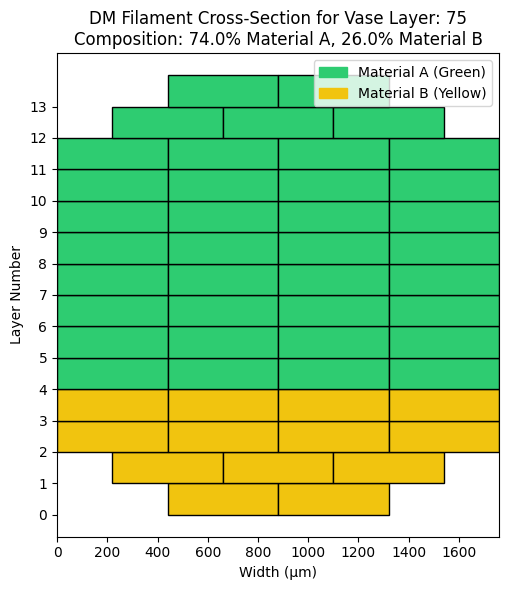

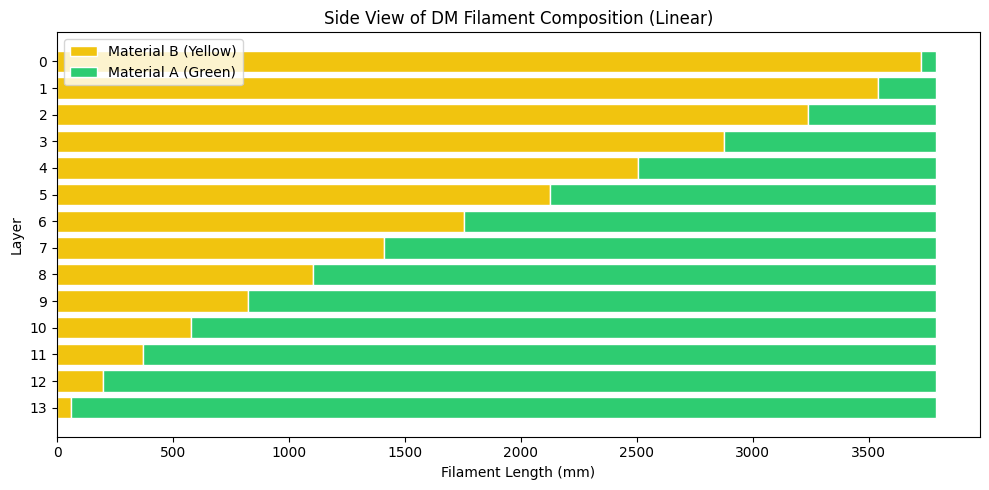

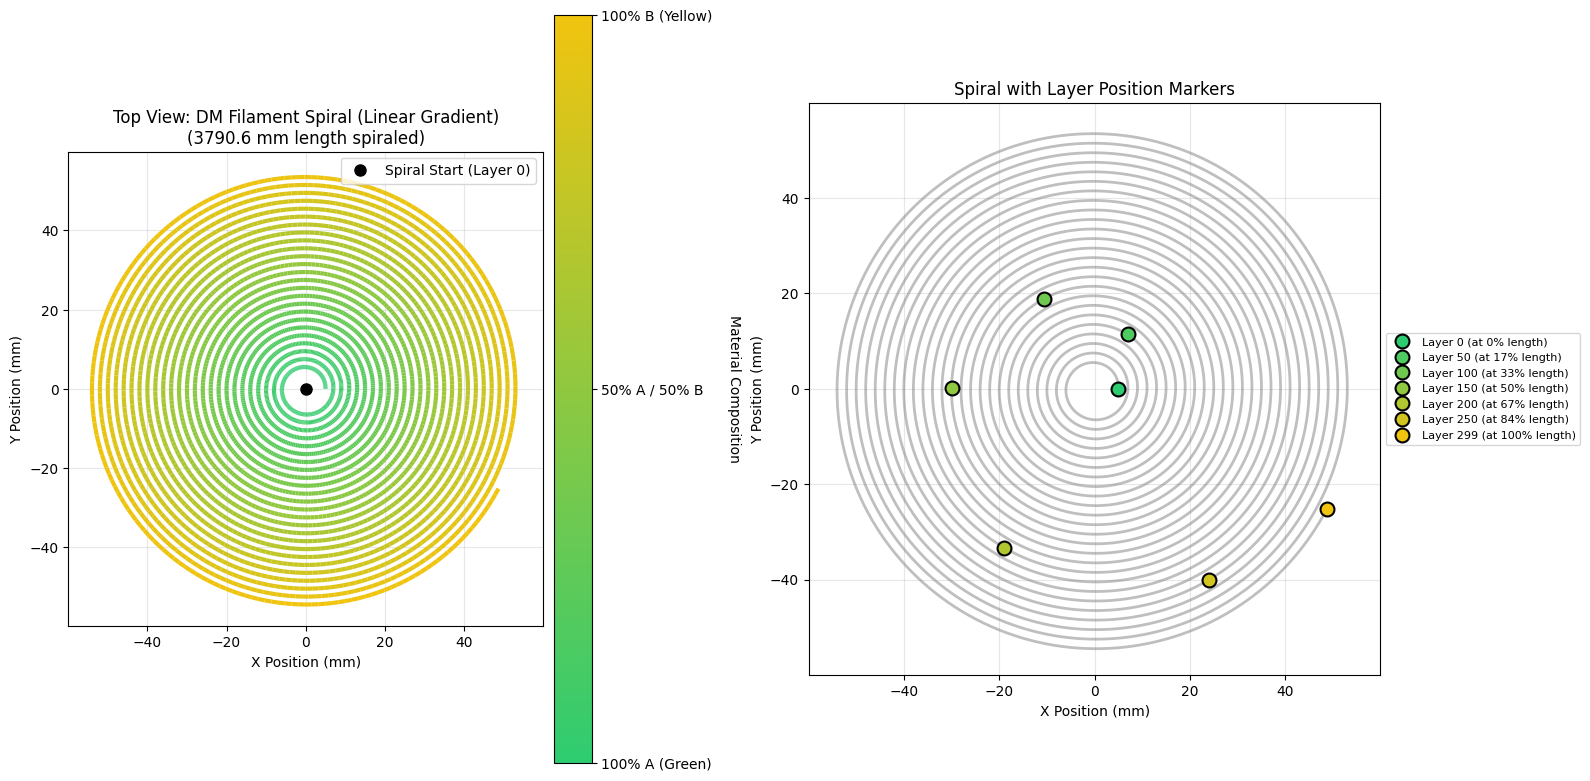


Generating 3D visualization of the vase...


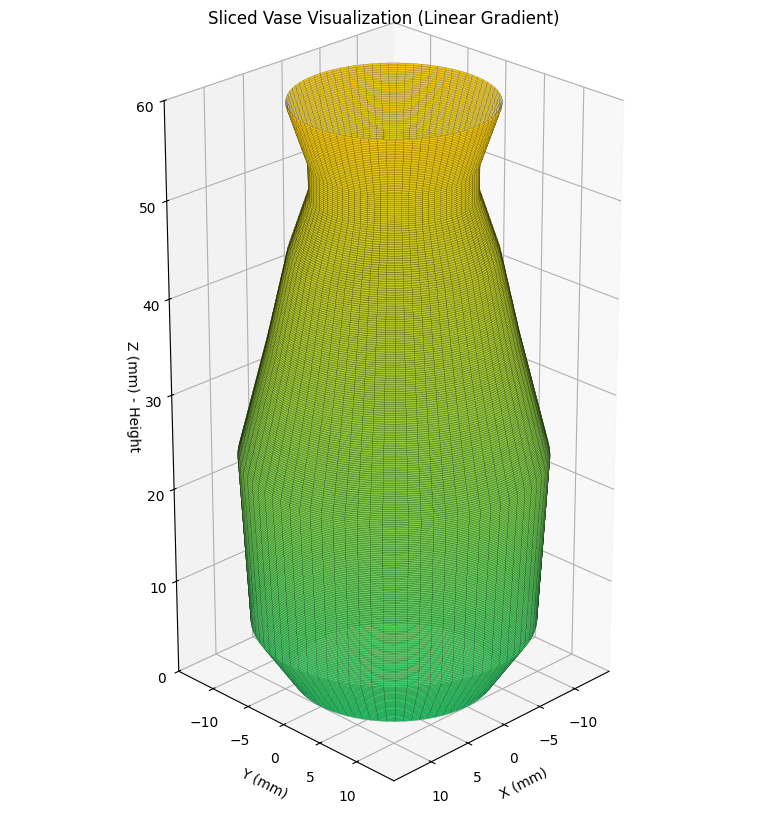

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ---------------------- PARAMETERS ----------------------

# --- Final Object (Vase) ---
VASE_HEIGHT_MM = 60.0
WALL_THICKNESS_MM = 2.2   # How thick the vase wall is
FINAL_LAYER_HEIGHT_MM = 0.2
TOTAL_FINAL_LAYERS = int(VASE_HEIGHT_MM / FINAL_LAYER_HEIGHT_MM)

# --- Vase Shape Definition ---
# [Height %, Radius in mm]
VASE_SHAPE_KNOTS_Z = [0.0,  0.05, 0.1,  0.4,  0.6,  0.75, 0.85, 0.9,  0.95, 1.0]  # Z-height (0% to 100%)
VASE_SHAPE_KNOTS_R = [10.0, 12.0, 14.0, 15.0, 12.0, 10.0, 8.0, 8.0, 9.0, 10.0] # Radius at that height

# --- Print Settings ---
EXTRUSION_WIDTH_MM = 0.44

# --- DM Filament (unchanged) ---
FILAMENT_DIAMETER_MM = 1.75
FILAMENT_LAYERS = 14
RECT_HEIGHT_UM = 125
RECT_WIDTH_UM = 440
RECTS_PER_LAYER = [2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 2]
TOTAL_RECTS = sum(RECTS_PER_LAYER)

# --- Spiral Settings ---
SPIRAL_START_RADIUS_MM = 5.0
SPIRAL_SPACING_MM = 2.0

# --- 3D Visualization Settings ---
VASE_MESH_SEGMENTS = 80 # Number of segments to make the 3D vase look smooth

# --- Colors (Green & Yellow) ---
COLOR_A_HEX = '#2ecc71'  # Green
COLOR_B_HEX = '#f1c40f'  # Yellow
COLOR_A_RGB = np.array([46, 204, 113]) / 255.0  # Green
COLOR_B_RGB = np.array([241, 196, 15]) / 255.0   # Yellow

# ------------------------------------------------------------------
# ### 1. Helper Functions (Gradient & Cross-Section)
# ------------------------------------------------------------------

def get_layer_color_linear(layer_index, total_layers):
    """
    Calculates the RGB color for a given layer based on a LINEAR gradient.
    """
    if total_layers == 1:
        return COLOR_A_RGB
    normalized_layer = layer_index / (total_layers - 1)
    
    # Apply a linear function
    percentage_B = normalized_layer
    
    color = COLOR_A_RGB * (1 - percentage_B) + COLOR_B_RGB * percentage_B
    return color

def generate_filament_cross_section(target_layer_index, total_final_layers):
    """
    Generates material distribution for a single filament segment.
    Uses a LINEAR gradient and bottom-up filling.
    """
    if not (0 <= target_layer_index < total_final_layers):
        raise ValueError("target_layer_index must be between 0 and total_final_layers - 1.")

    normalized_layer = target_layer_index / (total_final_layers - 1)
    # Apply a linear function
    percentage_B = normalized_layer
    
    num_B_rects_target = round(TOTAL_RECTS * percentage_B)
    cross_section = []
    rects_assigned_so_far = 0
    for num_rects_in_layer in RECTS_PER_LAYER:
        layer_composition = []
        for _ in range(num_rects_in_layer):
            if rects_assigned_so_far < num_B_rects_target:
                layer_composition.append('B')
            else:
                layer_composition.append('A')
            rects_assigned_so_far += 1
        cross_section.append(layer_composition)
    return cross_section

def calculate_vase_radii():
    """
    Generates an array of radii, one for each layer, based on the shape knots.
    """
    z_points = np.linspace(0, 1, TOTAL_FINAL_LAYERS)
    radii = np.interp(z_points, VASE_SHAPE_KNOTS_Z, VASE_SHAPE_KNOTS_R)
    
    print(f"--- Vase Shape Parameters ---")
    print(f"Height: {VASE_HEIGHT_MM} mm, Total Layers: {TOTAL_FINAL_LAYERS}")
    print(f"Base Radius: {radii[0]:.2f} mm, Max Radius: {np.max(radii):.2f} mm")
    print(f"Neck Radius: {np.min(radii):.2f} mm, Lip Radius: {radii[-1]:.2f} mm")
    return radii

# ------------------------------------------------------------------
# ### 2. Filament Length & Composition
# ------------------------------------------------------------------

def calculate_filament_length_and_composition(vase_radii):
    """
    Calculates total filament length and aggregated composition for the vase.
    """
    area_filament = math.pi * (FILAMENT_DIAMETER_MM / 2)**2
    area_extrusion = FINAL_LAYER_HEIGHT_MM * EXTRUSION_WIDTH_MM
    length_ratio = area_extrusion / area_filament
    
    num_perimeters = max(1, int(round(WALL_THICKNESS_MM / EXTRUSION_WIDTH_MM)))
    
    print(f"\n--- Filament Length Calculation ---")
    print(f"Wall filled with {num_perimeters} perimeter(s).")
    
    layer_wise_lengths = [{'A': 0.0, 'B': 0.0} for _ in range(FILAMENT_LAYERS)]
    total_filament_length = 0.0
    
    for i in range(TOTAL_FINAL_LAYERS):
        outer_radius = vase_radii[i]
        inner_radius = max(0, outer_radius - WALL_THICKNESS_MM)
        
        perimeter_radii = [inner_radius + (k + 0.5) * EXTRUSION_WIDTH_MM for k in range(num_perimeters)]
        extruded_length_per_layer = sum([2 * math.pi * r for r in perimeter_radii])
        filament_length_per_layer = extruded_length_per_layer * length_ratio
        
        total_filament_length += filament_length_per_layer
        
        cross_section = generate_filament_cross_section(i, TOTAL_FINAL_LAYERS)
        for j, internal_layer in enumerate(cross_section):
            count_A = internal_layer.count('A')
            count_B = internal_layer.count('B')
            total_rects_in_layer = len(internal_layer)
            
            len_A_segment = (count_A / total_rects_in_layer) * filament_length_per_layer
            len_B_segment = (count_B / total_rects_in_layer) * filament_length_per_layer
            
            layer_wise_lengths[j]['A'] += len_A_segment
            layer_wise_lengths[j]['B'] += len_B_segment

    print(f"Total Filament Length: {total_filament_length:.2f} mm")
    
    return layer_wise_lengths, total_filament_length

# ------------------------------------------------------------------
# ### 3. Plotting Functions
# ------------------------------------------------------------------

def plot_cross_section(cross_section, layer_index):
    """
    Visualizes the DM filament cross-section for a given layer.
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    max_width = max(RECTS_PER_LAYER) * RECT_WIDTH_UM
    for i, layer in enumerate(cross_section):
        num_rects_in_layer = len(layer)
        start_x = (max_width - (num_rects_in_layer * RECT_WIDTH_UM)) / 2
        for j, material in enumerate(layer):
            color = COLOR_A_HEX if material == 'A' else COLOR_B_HEX
            y_pos = i * RECT_HEIGHT_UM
            x_pos = start_x + j * RECT_WIDTH_UM
            rect = patches.Rectangle(
                (x_pos, y_pos), RECT_WIDTH_UM, RECT_HEIGHT_UM,
                linewidth=1.0, edgecolor='black', facecolor=color
            )
            ax.add_patch(rect)
            
    ax.set_aspect('equal', adjustable='box')
    plt.xlim(0, max_width)
    total_height = FILAMENT_LAYERS * RECT_HEIGHT_UM
    plt.ylim(-total_height * 0.05, total_height * 1.05)
    plt.xlabel("Width (µm)")
    plt.ylabel("Layer Number")
    
    tick_positions = [i * RECT_HEIGHT_UM for i in range(FILAMENT_LAYERS)]
    tick_labels = [str(i) for i in range(FILAMENT_LAYERS)]
    plt.yticks(tick_positions, tick_labels)
    
    percentage_B = (sum(row.count('B') for row in cross_section) / TOTAL_RECTS) * 100
    title = (f"DM Filament Cross-Section for Vase Layer: {layer_index}\n"
             f"Composition: {100 - percentage_B:.1f}% Material A, {percentage_B:.1f}% Material B")
    plt.title(title)
    
    legend_patches = [
        patches.Patch(color=COLOR_A_HEX, label='Material A (Green)'),
        patches.Patch(color=COLOR_B_HEX, label='Material B (Yellow)')
    ]
    plt.legend(handles=legend_patches, loc='upper right')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def plot_filament_composition(layer_wise_lengths, total_filament_length):
    """
    Plots the aggregated side-view composition of the entire filament.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    layers = np.arange(FILAMENT_LAYERS)
    lengths_A = [d['A'] for d in layer_wise_lengths]
    lengths_B = [d['B'] for d in layer_wise_lengths]
    
    ax.barh(layers, lengths_B, color=COLOR_B_HEX, edgecolor='white', label='Material B (Yellow)')
    ax.barh(layers, lengths_A, left=lengths_B, color=COLOR_A_HEX, edgecolor='white', label='Material A (Green)')
    
    ax.set_xlabel('Filament Length (mm)')
    ax.set_ylabel('Layer')
    ax.set_title('Side View of DM Filament Composition (Linear)')
    ax.set_yticks(layers)
    ax.invert_yaxis()
    ax.legend()
    plt.tight_layout()
    plt.show()

def create_archimedean_spiral(total_length_mm, start_radius_mm, spacing_mm, num_points=5000):
    """
    Creates an Archimedean spiral path with a specific total length.
    """
    b = spacing_mm / (2 * np.pi)
    a = start_radius_mm
    theta_max = 20 * np.pi
    for iteration in range(10):
        theta = np.linspace(0, theta_max, num_points)
        r = a + b * theta
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        dx = np.diff(x)
        dy = np.diff(y)
        segment_lengths = np.sqrt(dx**2 + dy**2)
        current_length = np.sum(segment_lengths)
        if current_length == 0: break
        theta_max *= total_length_mm / current_length
        if abs(current_length - total_length_mm) < 0.1:
            break
    return x, y, theta

# --- THIS IS THE UPDATED FUNCTION ---
def plot_spiral_filament_gradient(total_filament_length):
    """
    Visualizes the DM filament as a spiral with a LINEAR color gradient
    and a second plot with layer markers.
    """
    x, y, theta = create_archimedean_spiral(
        total_filament_length,
        SPIRAL_START_RADIUS_MM,
        SPIRAL_SPACING_MM
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    cmap = LinearSegmentedColormap.from_list('material_gradient', [COLOR_A_HEX, COLOR_B_HEX])

    # --- LEFT PLOT: Spiral with gradient ---
    num_points = len(x)
    
    # Linear gradient logic
    colors = np.linspace(0, 1, num_points)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, linewidth=3)
    lc.set_array(colors)
    line = ax1.add_collection(lc)

    ax1.set_aspect('equal')
    max_extent = max(np.max(np.abs(x)), np.max(np.abs(y))) * 1.1
    ax1.set_xlim(-max_extent, max_extent)
    ax1.set_ylim(-max_extent, max_extent)
    ax1.set_xlabel('X Position (mm)')
    ax1.set_ylabel('Y Position (mm)')
    ax1.set_title(f'Top View: DM Filament Spiral (Linear Gradient)\n({total_filament_length:.1f} mm length spiraled)')
    ax1.grid(True, alpha=0.3)

    cbar = plt.colorbar(line, ax=ax1, orientation='vertical', pad=0.02)
    cbar.set_label('Material Composition', rotation=270, labelpad=20)
    cbar.set_ticks([0, 0.5, 1.0])
    cbar.set_ticklabels(['100% A (Green)', '50% A / 50% B', '100% B (Yellow)'])

    ax1.plot(0, 0, 'ko', markersize=8, label='Spiral Start (Layer 0)')
    ax1.legend(loc='upper right')

    # --- RIGHT PLOT: Spiral with layer markers ---
    ax2.plot(x, y, 'gray', linewidth=2, alpha=0.5)

    step = 50
    layer_markers = list(range(0, TOTAL_FINAL_LAYERS, step))
    last_layer = TOTAL_FINAL_LAYERS - 1
    if layer_markers[-1] != last_layer:
        layer_markers.append(last_layer)
    
    # Linear color logic for markers
    marker_colors = [cmap(i / last_layer) for i in layer_markers]

    for layer_idx, color in zip(layer_markers, marker_colors):
        # Position is still linear along the length
        idx = int(layer_idx / (TOTAL_FINAL_LAYERS - 1) * (len(x) - 1))
        percentage_length = (layer_idx / (TOTAL_FINAL_LAYERS - 1)) * 100
        ax2.plot(x[idx], y[idx], 'o', color=color, markersize=10,
                 markeredgecolor='black', markeredgewidth=1.5,
                 label=f'Layer {layer_idx} (at {percentage_length:.0f}% length)')

    ax2.set_aspect('equal')
    ax2.set_xlim(-max_extent, max_extent)
    ax2.set_ylim(-max_extent, max_extent)
    ax2.set_xlabel('X Position (mm)')
    ax2.set_ylabel('Y Position (mm)')
    ax2.set_title(f'Spiral with Layer Position Markers')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)

    plt.tight_layout()
    plt.show()
# --- END OF UPDATED FUNCTION ---


def visualize_sliced_vase(vase_radii):
    """
    Creates a 3D plot of the hollow vase, showing individual layers
    and color gradient on the outer wall.
    """
    print("\nGenerating 3D visualization of the vase...")
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    theta = np.linspace(0, 2 * np.pi, VASE_MESH_SEGMENTS)

    for i in range(TOTAL_FINAL_LAYERS):
        outer_radius = vase_radii[i]
        z_bottom = i * FINAL_LAYER_HEIGHT_MM
        z_top = (i + 1) * FINAL_LAYER_HEIGHT_MM
        color = get_layer_color_linear(i, TOTAL_FINAL_LAYERS)
        
        x_out = outer_radius * np.cos(theta)
        y_out = outer_radius * np.sin(theta)
        
        verts = []
        for j in range(VASE_MESH_SEGMENTS - 1):
            v1 = (x_out[j], y_out[j], z_bottom)
            v2 = (x_out[j+1], y_out[j+1], z_bottom)
            v3 = (x_out[j+1], y_out[j+1], z_top)
            v4 = (x_out[j], y_out[j], z_top)
            verts.append([v1, v2, v3, v4])
            
        poly = Poly3DCollection(verts, facecolors=color, edgecolor='k', linewidth=0.1)
        ax.add_collection3d(poly)

    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm) - Height')
    ax.set_title('Sliced Vase Visualization (Linear Gradient)')
    
    max_radius = np.max(vase_radii)
    ax.set_xlim([-max_radius, max_radius])
    ax.set_ylim([-max_radius, max_radius])
    ax.set_zlim([0, VASE_HEIGHT_MM])
    ax.set_box_aspect([1, 1, VASE_HEIGHT_MM / (max_radius * 2)])
    ax.view_init(elev=25, azim=45)
    
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# ### MAIN EXECUTION
# ------------------------------------------------------------------

if __name__ == "__main__":
    
    # 1. Define the vase shape
    vase_radii = calculate_vase_radii()
    
    # 2. Calculate filament length and composition data
    layer_wise_lengths, total_filament_length = calculate_filament_length_and_composition(vase_radii)
    
    # 3. Run Plot #1: Cross-section of a representative layer
    rep_layer = min(75, TOTAL_FINAL_LAYERS - 1)
    plot_cross_section(generate_filament_cross_section(rep_layer, TOTAL_FINAL_LAYERS), rep_layer)
    
    # 4. Run Plot #2: Side-view aggregated composition
    plot_filament_composition(layer_wise_lengths, total_filament_length)
    
    # 5. Run Plot #3: Spiral top-view of the full filament
    plot_spiral_filament_gradient(total_filament_length)
    
    # 6. Run Plot #4: 3D visualization of the final vase
    visualize_sliced_vase(vase_radii)